In [30]:
import os
import kagglehub
from google.colab import drive
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

##Preprocesamiento

In [3]:
#=======================
# Descragar dataset
#=======================
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [4]:
ruta_base = os.path.join(path, 'chest_xray')

In [5]:
# ============================================
# Conteo de imágenes por clase en cada conjunto
# ============================================

for tipo in ['train', 'val', 'test']:
    ruta_tipo = os.path.join(ruta_base, tipo)


    total_normal = len(os.listdir(os.path.join(ruta_tipo, 'NORMAL')))
    total_neumonia = len(os.listdir(os.path.join(ruta_tipo, 'PNEUMONIA')))

    print(f"Conjunto: {tipo.upper()}")
    print(f"  Imágenes normales : {total_normal}")
    print(f"  Imágenes con neumonía : {total_neumonia}")
    print("-" * 40)

Conjunto: TRAIN
  Imágenes normales : 1341
  Imágenes con neumonía : 3875
----------------------------------------
Conjunto: VAL
  Imágenes normales : 8
  Imágenes con neumonía : 8
----------------------------------------
Conjunto: TEST
  Imágenes normales : 234
  Imágenes con neumonía : 390
----------------------------------------


NOTA: El conjunto de validación contiene muy pocas imagenes por lo que las agregaremos al conjunto de entrenamiento y generaremos un nuevo conjunto de validación con 80% entrenamineto y 20% validación

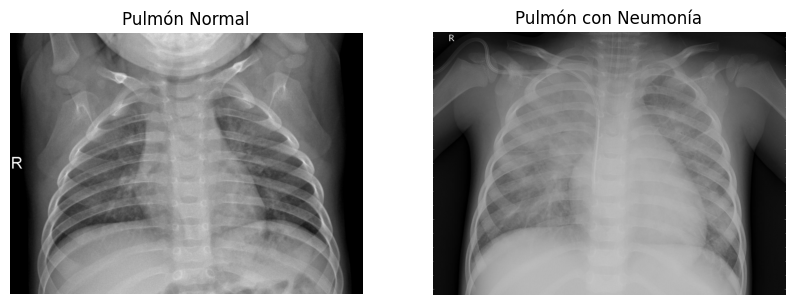

In [8]:
# ============================================
# Visualización de imágenes del dataset
# Chest X-Ray (Normal vs Neumonía)
# ============================================

ruta_normal = os.path.join(ruta_base, 'train', 'NORMAL')
ruta_neumonia = os.path.join(ruta_base, 'train', 'PNEUMONIA')


imagen_normal = os.path.join(ruta_normal, random.choice(os.listdir(ruta_normal)))
imagen_neumonia = os.path.join(ruta_neumonia, random.choice(os.listdir(ruta_neumonia)))


img_normal = mpimg.imread(imagen_normal)
img_neumonia = mpimg.imread(imagen_neumonia)


fig, ejes = plt.subplots(1, 2, figsize=(10, 5))

ejes[0].imshow(img_normal, cmap='gray')
ejes[0].set_title('Pulmón Normal')
ejes[0].axis('off')

ejes[1].imshow(img_neumonia, cmap='gray')
ejes[1].set_title('Pulmón con Neumonía')
ejes[1].axis('off')

plt.show()


NOTA: Aplicamos un preprocesamiento a las imagenes para aumnetar la variación en el entrenamiento y además normalizamos las imagenes para que todas tengan el mismo tamaño

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


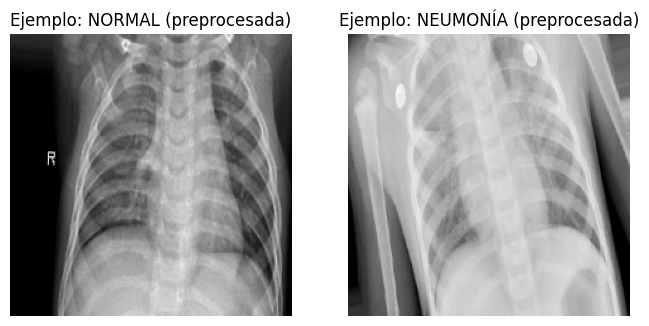

In [12]:
# ============================================
# Preprocesamiento de imágenes y aumento de datos
# ============================================

generador_entrenamiento = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # <-- 80% entrenamiento, 20% validación
)

# Parámetros base
tamaño_imagen = (224, 224)
tamaño_lote = 32

# Conjunto de entrenamiento (80%)
train_gen = generador_entrenamiento.flow_from_directory(
    os.path.join(ruta_base, 'train'),
    target_size=tamaño_imagen,
    batch_size=tamaño_lote,
    class_mode='binary',
    subset='training'
)

# Conjunto de validación (20%)
val_gen = generador_entrenamiento.flow_from_directory(
    os.path.join(ruta_base, 'train'),
    target_size=tamaño_imagen,
    batch_size=tamaño_lote,
    class_mode='binary',
    subset='validation'
)

# Conjunto de prueba (sin aumento)
generador_simple = ImageDataGenerator(rescale=1.0/255)
test_gen = generador_simple.flow_from_directory(
    os.path.join(ruta_base, 'test'),
    target_size=tamaño_imagen,
    batch_size=tamaño_lote,
    class_mode='binary',
    shuffle=False
)

# ============================================
# Visualización de imágenes preprocesadas
# ============================================


imagenes, etiquetas = next(train_gen)


indice_normal = np.where(etiquetas == 0)[0][0]
indice_neumonia = np.where(etiquetas == 1)[0][0]


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(imagenes[indice_normal])
plt.title("Ejemplo: NORMAL (preprocesada)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagenes[indice_neumonia])
plt.title("Ejemplo: NEUMONÍA (preprocesada)")
plt.axis('off')

plt.show()


In [13]:
#=============================
#Calcular pesos de clase
#=============================


ruta_train = os.path.join(ruta_base, 'train')
normal_count = len(os.listdir(os.path.join(ruta_train, 'NORMAL')))
neumonia_count = len(os.listdir(os.path.join(ruta_train, 'PNEUMONIA')))

# Etiquetas de clase: 0 = NORMAL, 1 = NEUMONIA
clases = np.array([0] * normal_count + [1] * neumonia_count)


pesos = compute_class_weight(class_weight='balanced', classes=np.unique(clases), y=clases)

pesos_dict = {0: pesos[0], 1: pesos[1]}
print("Pesos de clase calculados:")
print(pesos_dict)


Pesos de clase calculados:
{0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


NOTA: El dataset se encuentra desbalaceado ya que contiene más imagenes de X-ray con neumonia por lo que calculamos los pesos de cada clase para poder balancear dichos pesos en el entrenamiento

##Entrenamiento deL modelo CNN

In [14]:
modelo = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # salida binaria
])


modelo.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

historial = modelo.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=pesos_dict,  # usar los pesos calculados
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 642s 5s/step - accuracy: 0.6935 - loss: 0.5814 - val_accuracy: 0.7795 - val_loss: 0.5120
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 632s 5s/step - accuracy: 0.8388 - loss: 0.3606 - val_accuracy: 0.8543 - val_loss: 0.3220
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 626s 5s/step - accuracy: 0.8496 - loss: 0.3359 - val_accuracy: 0.8639 - val_loss: 0.3304
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 625s 5s/step - accuracy: 0.8789 - loss: 0.3050 - val_accuracy: 0.8888 - val_loss: 0.2815
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 623s 5s/step - accuracy: 0.8826 - loss: 0.2611 - val_accuracy: 0.8696 - val_loss: 0.2769
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 625s 5s/step - accuracy: 0.8753 - loss: 0.2994 - val_accuracy: 0.8610 - val_loss: 0.3008
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 626s 5s/step - accuracy: 0.8978 - loss: 0.2505 - val_accuracy: 0.8888 - val_loss: 0.2808
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 619s 5s/step - accuracy: 0.9032 - loss: 0.2406 - val_accu

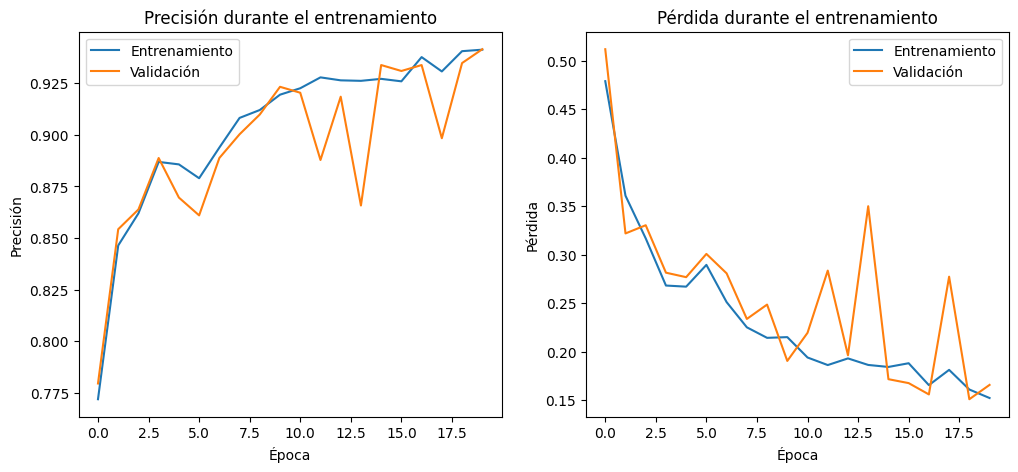

In [15]:
# ============================================
# Visualizar desempeño del entrenamiento
# ============================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historial.history['accuracy'], label='Entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historial.history['loss'], label='Entrenamiento')
plt.plot(historial.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step

Reporte de clasificación:
              precision    recall  f1-score   support

      NORMAL       0.91      0.81      0.86       234
   PNEUMONIA       0.89      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



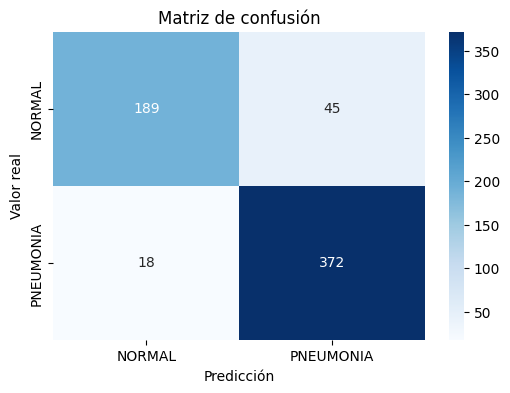

In [16]:
# ============================================
# Matriz de confusión y reporte de clasificación
# ============================================

pred_prob = modelo.predict(test_gen)

pred_clases = (pred_prob > 0.5).astype("int32")

y_true = test_gen.classes

class_labels = list(test_gen.class_indices.keys())

matriz = confusion_matrix(y_true, pred_clases)

print("\nReporte de clasificación:")
print(classification_report(y_true, pred_clases, target_names=class_labels))

plt.figure(figsize=(6,4))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de confusión")
plt.show()


In [23]:
modelo.save('/content/drive/MyDrive/ColabNotebooks/ML/Taller5/cnn_neumonia_modelo.h5')
print("Modelo guardado en Drive.")

Modelo guardado en Drive.


In [24]:
modelo = load_model('/content/drive/MyDrive/ColabNotebooks/ML/Taller5/cnn_neumonia_modelo.h5')
print("Modelo cargado correctamente.")

Modelo cargado correctamente.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔹 Analizando: chest-xray-N.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


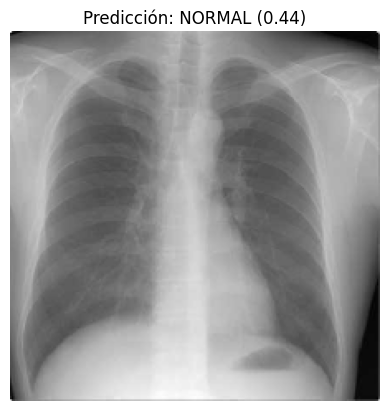

--------------------------------------------------
🔹 Analizando: chest-xray-P.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


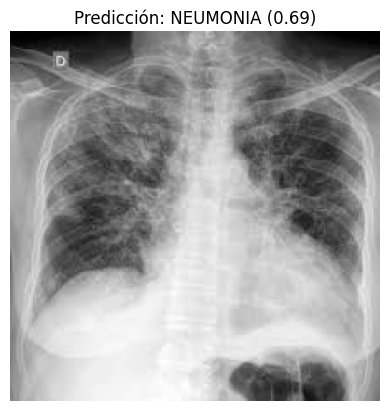

--------------------------------------------------


In [32]:
drive.mount('/content/drive')

ruta_nuevas = '/content/drive/MyDrive/ColabNotebooks/ML/Taller5/images_test'

# ===========================================
# 4. Cargar y predecir imágenes nuevas
# ===========================================
tamaño_imagen = (224, 224)
extensiones = ('.jpg', '.jpeg', '.png')

imagenes_nuevas = [f for f in os.listdir(ruta_nuevas) if f.lower().endswith(extensiones)]

def predecir_imagen(ruta_img):
    img = image.load_img(ruta_img, target_size=tamaño_imagen)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    pred = modelo.predict(img_array)
    clase = "NEUMONIA" if pred[0][0] > 0.5 else "NORMAL"
    prob = pred[0][0]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicción: {clase} ({prob:.2f})")
    plt.show()

for nombre_img in imagenes_nuevas:
    ruta_img = os.path.join(ruta_nuevas, nombre_img)
    print(f"🔹 Analizando: {nombre_img}")
    predecir_imagen(ruta_img)
    print("-" * 50)
